# Sparse PLS

In [2]:
import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings('ignore', category=TqdmExperimentalWarning)

import numpy as np
import xarray as xr
import pandas as pd

from scipy.stats import zscore, pearsonr

from sklearn.decomposition import PCA
from sklearn.utils import check_random_state
from sklearn.model_selection import KFold

from gemmr.generative_model import GEMMR, JointCovarianceModelPLS
from gemmr.generative_model.base import PLSgm, CCAgm
from gemmr.estimators import SVDCCA, SVDPLS
from gemmr.estimators.r_estimators import SparsePLS
from gemmr.sample_analysis.analyzers import analyze_model
from gemmr.sample_analysis import addon, postproc
from gemmr.util import _calc_true_loadings

import holoviews as hv
hv.extension('matplotlib')
from holoviews import opts
hv.renderer('matplotlib').param.set_param(dpi=120)

from my_config import *

from tqdm.notebook import tqdm, trange

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [2]:
clr_spls = 'mediumvioletred'
clrs = dict(
    SVDPLS=clr_pls,
    SVDCCA=clr_cca,
    SparsePLS=clr_spls
)

:Curve   [x]   (y)
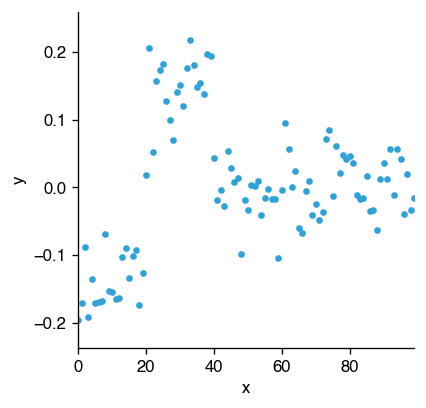

In [3]:
# Witten et al. (2009): Fig. 4 and Appendix 3
n = 50
random_seed = 0

rng = np.random.default_rng(random_seed)

ex = rng.normal(scale=.3, size=(n, 100))
ey = rng.normal(scale=.3, size=(n, 100))
W = np.linalg.qr(rng.normal(size=(n, n)))[0]
w1, w2 = W[:, [0]], W[:, [1]]
u1 = np.r_[[1]*20, [-1]*20, [0]*60].reshape(-1, 1)
u2 = np.r_[[-1]*10, [1]*10, [-1]*10, [1]*10, [0]*60].reshape(-1, 1)
v1 = np.r_[[0]*60, [-1]*20, [1]*20].reshape(-1, 1)
v2 = np.r_[[0]*60, [1]*10, [-1]*10, [1]*10, [-1]*10].reshape(-1, 1)

X = w1 @ u1.T + w2 @ u2.T + ex
Y = w1 @ v1.T + w2 @ u2.T + ey

Sxy = X.T @ Y / n

hv.Curve(np.linalg.svd(Sxy)[0][:, 0]).opts(linestyle='', marker='.')

[0.91153997]


:Curve   [x]   (y)
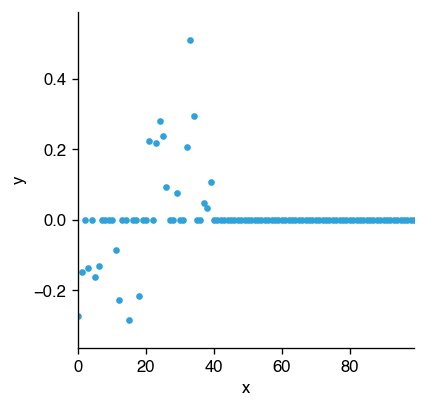

In [4]:
penalties = np.arange(.1, 1.01, .1)
scca = SparsePLS(penaltyxs=[.2, .3, .4], penaltyys=[.2, .3, .4], penalty_pairing='product', niter=100, cv=5).fit(X, Y)
print(scca.corrs_)
hv.Curve(scca.x_rotations_[:, 0]).opts(linestyle='', marker='.')

In [5]:
rng = np.random.default_rng(seed=0)

Sxx = 4*u1@u1.T/n + u2@u2.T/n + (.9)*np.eye(len(u1))
Syy = 4*v1@v1.T/n + v2@v2.T/n + (.9)*np.eye(len(v1))
Sxy = 4*u1@v1.T/n + u2@v2.T/n +  u1 @ rng.normal(scale=.003, size=(1, len(u1))) + rng.normal(scale=.003, size=(len(v1), 1)) @ v1.T

S =  np.vstack([
    np.hstack([Sxx, Sxy]),
    np.hstack([Sxy.T, Syy])
])

jcov = JointCovarianceModelPLS(S, len(u1), m=1)
jcov.true_corrs_

array([0.78143672])

:Layout
   .Curve.Uniform         :Curve   [x]   (y)
   .Curve.Random          :Curve   [x]   (y)
   .Curve.Decay           :Curve   [x]   (y)
   .Curve.Rise            :Curve   [x]   (y)
   .Curve.Step_down       :Curve   [x]   (y)
   .Curve.Step_up         :Curve   [x]   (y)
   .Curve.Spikes          :Curve   [x]   (y)
   .Curve.Decaying_spikes :Curve   [x]   (y)
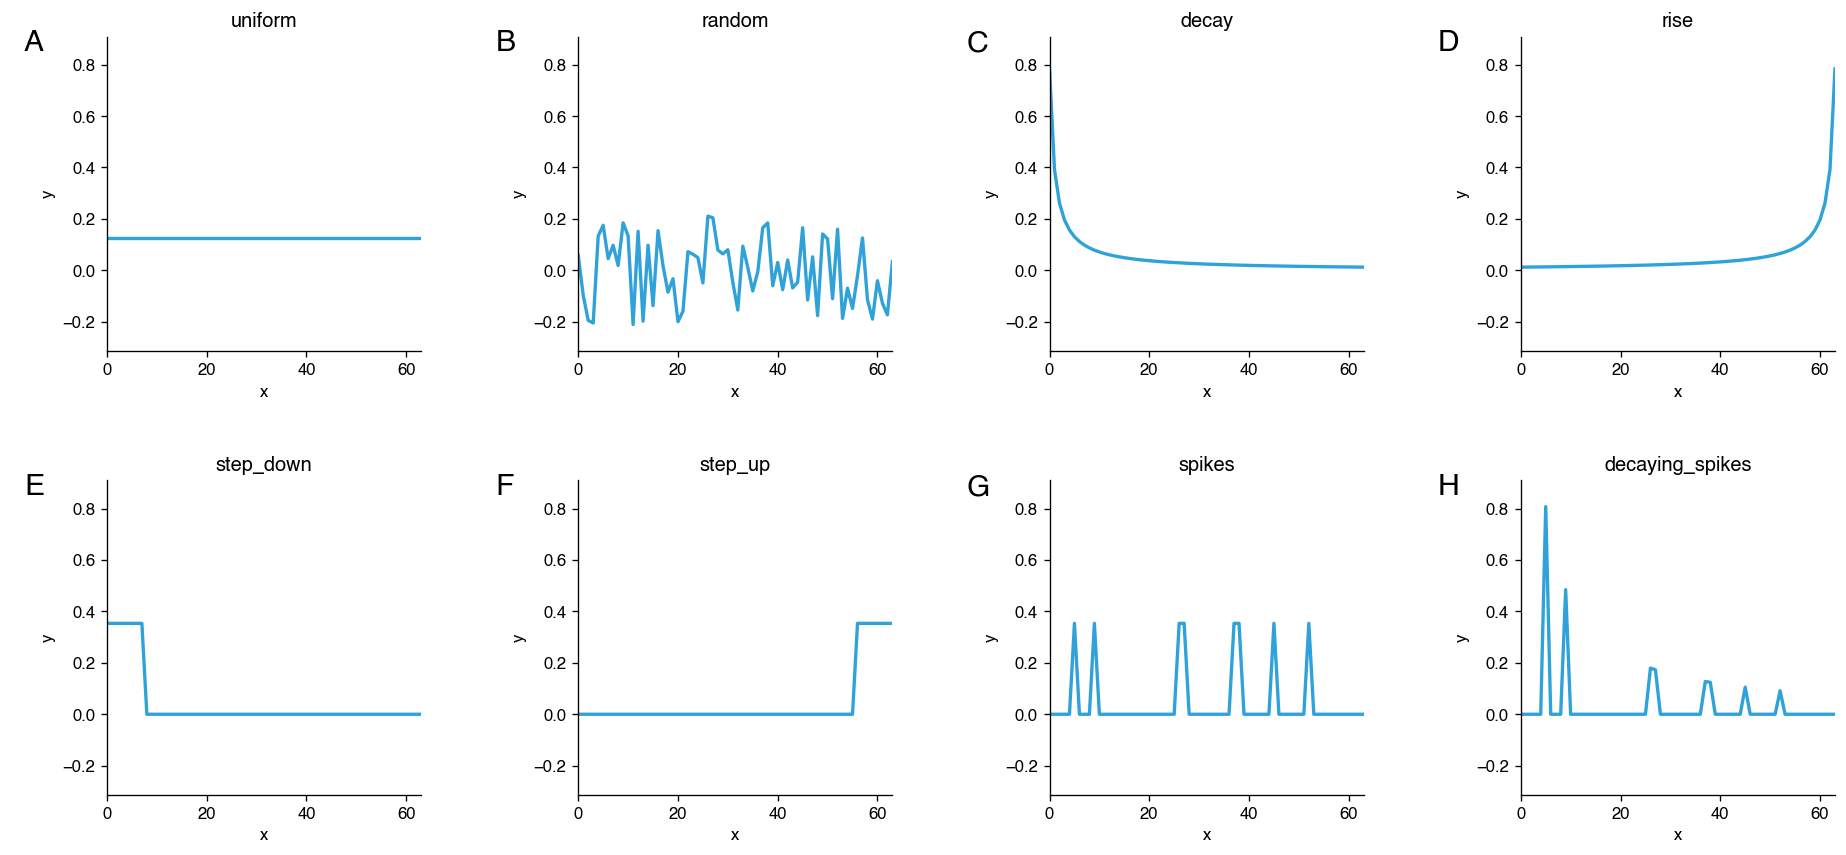

In [6]:
px = 64
weights = dict(
    uniform=np.ones(px),
    random=np.random.default_rng(0).uniform(-1, 1, size=px),
    decay=(np.arange(1, px+1) ** -1.),
    rise=(np.arange(1, px+1) ** -1.)[::-1],
    step_down=np.r_[np.ones(px//8), np.zeros(7*px//8)],
    step_up=np.r_[np.zeros(7*px//8), np.ones(1*px//8)],
    spikes=np.random.default_rng(0).binomial(n=1, p=1./8, size=px), #* (np.arange(1, px+1) ** -1.),
    decaying_spikes=np.random.default_rng(0).binomial(n=1, p=1./8, size=px) * (np.arange(1, px+1) ** -1.),
)

for k in weights:
    weights[k] = weights[k] / np.linalg.norm(weights[k], keepdims=True)

fig = hv.Layout()
for k in weights:
    fig += hv.Curve(weights[k]).relabel(k)

fig

In [7]:
import rpy2.robjects
rpy2.robjects.r("Sys.setenv('R_MAX_VSIZE'=128000000000)")

1


In [8]:
# ## Takes a while to run

# ax, ay = -1., -1.

# penalties = [.1, .3, .5]

# ress = []
# for w_lbl in weights:  # ['decay', 'step_down']:
#     w = weights[w_lbl]
#     plsgm = PLSgm(w.reshape(-1, 1), w.reshape(-1, 1), ax=ax, ay=ay, r_between=0.3)
#     res = analyze_model(
#         plsgm, 
#         [
#             SVDPLS(),
#             SparsePLS(penaltyxs=penalties, penaltyys=penalties, penalty_pairing='zip')
#         ],
#         n_per_ftrs=(1, 16, 256, ),
#         check_convergence=False,
#         n_rep=25,
#         n_test=1000,
#         addons=[
#             addon.test_scores, addon.weights_true_cossim, addon.loadings_true_pearson, addon.test_scores_true_pearson, addon.test_scores_true_spearman, addon.sparseCCA_penalties, #addon.cv
#             ],
#         postprocessors=[postproc.weights_pairwise_cossim_stats, postproc.weights_pairwise_jaccard_stats],
#         #true_loadings=_calc_true_loadings(plsgm.Sigma_, plsgm.px, plsgm.x_rotations_[:, :1], plsgm.y_rotations_[:, :1]),
#         cvs=[('kfold5', KFold(5))],
#         scorers=addon.mk_scorers_for_cv(),
#         mk_test_statistics=addon.mk_test_statistics_scores,
#         random_state=0
#     )
#     res['weight'] = w_lbl
#     ress.append(res)
# res_pls = xr.concat(ress, 'weight')

# res_pls.to_netcdf('pls_vs_spls.nc')

In [9]:
res_pls = xr.open_dataset('pls_vs_spls.nc')

In [10]:
def avg_weights(xw):
    xw = xw# .mean('rep')
    assert xw.ndim == 2
    xw = xw / np.linalg.norm(xw.mean('rep'))
    return xw


def plot_comparison(xw_pls, xw_spls, xw_true, show_xlabel=True, qs=(.025, .975)):
    if show_xlabel:
        xlabel = None
    else:
        xlabel = ''

    xw_pls_mean = xw_pls.mean('rep')
    xw_spls_mean = xw_spls.mean('rep')

    if xw_pls_mean.values @ xw_true < 0:
        xw_pls *= -1
    if xw_spls_mean.values @ xw_true < 0:
        xw_spls *= -1
                
    return (
        hv.Area((xw_pls.x_feature, xw_pls.quantile(qs[0], 'rep'), xw_pls.quantile(qs[1], 'rep')), vdims=['y', 'y2']).opts(color=clr_pls)
        * hv.Area((xw_spls.x_feature, xw_spls.quantile(qs[0], 'rep'), xw_spls.quantile(qs[1], 'rep')), vdims=['y', 'y2']).opts(color=clr_spls)
        * hv.Curve(xw_pls_mean, label='PLS').opts(color=clr_pls, linewidth=2.5) 
        * hv.Curve(xw_spls_mean, label='SPLS').opts(color=clr_spls, linestyle='--', linewidth=2.5)
        * hv.Curve(xw_true, label='Ground truth').opts(color='black', linewidth=2, linestyle=':')
    ).redim(
        x='PC',
        y='Weight'
    ).opts(
        opts.Area(linewidth=1, alpha=.2),
        opts.Overlay(padding=.02, xlabel=xlabel, ylim=(-1, 1), sublabel_position=(-.45, .95))
    )


def plot_stability(res, show_xlabel=True):
    if show_xlabel:
        xlabel = None
    else:
        xlabel = ''
    panel = hv.Overlay()
    ls = dict(SVDPLS='-', SparsePLS='--')
    for estr in res.estr.values:
        panel *= (
            hv.Area(
                (res.x_weights_pairwise_cossim_stats.n_per_ftr,
                 res.x_weights_pairwise_cossim_stats.sel(mode=0, estr=estr, stat='q2.5%'),
                 res.x_weights_pairwise_cossim_stats.sel(mode=0, estr=estr, stat='q97.5%')
                 ), 
                vdims=['y', 'y2']
            ).opts(color=clrs[estr])
            * hv.Curve(res.x_weights_pairwise_cossim_stats.sel(mode=0, stat='mean', estr=estr)).opts(color=clrs[estr], linestyle=ls[estr])
        )
    return panel.redim(
        n_per_ftr='Samples / feature',
        x_weights_pairwise_cossim_stats='Weight stability',
    ).opts(
        opts.Area(linewidth=0, alpha=.3),
        opts.Overlay(xlim=(.1, None), ylim=(0, 1), logx=True, xlabel=xlabel, sublabel_position=(-.75, .95))
    )


def plot_weight_type(res, show_xlabel=True, show_titel=True, show_legend=True, n_per_ftrs=None):

    if n_per_ftrs is None:
        n_per_ftrs = res.dropna('n_per_ftr', how='any', subset=['x_weights_true_cossim']).n_per_ftr.values
        n_per_ftrs = [n_per_ftrs[0], n_per_ftrs[1], n_per_ftrs[-1]]

    fig = hv.Layout()
    for n_per_ftr in n_per_ftrs:
        if show_titel:
            if int(n_per_ftr) == n_per_ftr:
                n_per_ftr = int(n_per_ftr)
            title = f'{n_per_ftr} samples / feature'
        else:
            title = f'{n_per_ftr} samples / feature'

        if n_per_ftr == res.n_per_ftr.values[0]:
            ylabel = None
        else:
            ylabel = ''
            show_legend = False

        panel = plot_comparison(
            res.sel(mode=0).x_weights.sel(estr='SVDPLS', n_per_ftr=n_per_ftr),
            res.sel(mode=0).x_weights.sel(estr='SparsePLS', n_per_ftr=n_per_ftr),
            res.sel(mode=0).x_weights_true.values,
            show_xlabel=show_xlabel
        ).opts(title=title)

        fig += panel.opts(ylabel=ylabel, show_legend=show_legend)
        
    fig += plot_stability(res, show_xlabel=show_xlabel)
    fig.cols(
        4
    ).opts(*fig_opts).opts(
        opts.Overlay(hooks=[legend_frame_off]),
        opts.Layout(fig_inches=(7, 10))
    )
    return fig

def plot_all(res, n_per_ftrs=None):
    fig = hv.Layout()
    for w in res.weight.values:
        if w == res.weight.values[-1]:
            show_xlabel = True
        else:
            show_xlabel = False
            
        if w == res.weight.values[0]:
            show_titel = True
            show_legend = True
        else:
            show_titel = False
            show_legend = False

        fig += plot_weight_type(res.sel(weight=w), show_xlabel=show_xlabel, show_titel=show_titel, show_legend=show_legend, n_per_ftrs=n_per_ftrs)
        
    return fig.opts(*fig_opts).opts(
        opts.Layout(fig_inches=(7, None))
    )

:Layout
   .Overlay.I      :Overlay
      .Area.I             :Area   [PC]   (Weight,y2)
      .Area.II            :Area   [PC]   (Weight,y2)
      .Curve.PLS          :Curve   [x_feature]   (x_weights)
      .Curve.SPLS         :Curve   [x_feature]   (x_weights)
      .Curve.Ground_truth :Curve   [PC]   (Weight)
   .Overlay.II     :Overlay
      .Area.I             :Area   [PC]   (Weight,y2)
      .Area.II            :Area   [PC]   (Weight,y2)
      .Curve.PLS          :Curve   [x_feature]   (x_weights)
      .Curve.SPLS         :Curve   [x_feature]   (x_weights)
      .Curve.Ground_truth :Curve   [PC]   (Weight)
   .Overlay.III    :Overlay
      .Area.I             :Area   [PC]   (Weight,y2)
      .Area.II            :Area   [PC]   (Weight,y2)
      .Curve.PLS          :Curve   [x_feature]   (x_weights)
      .Curve.SPLS         :Curve   [x_feature]   (x_weights)
      .Curve.Ground_truth :Curve   [PC]   (Weight)
   .Overlay.IV     :Overlay
      .Area.I   :Area   [x]   (y,y2)
      .Curve.I  :Curve   [Samples / feature]   (Weight stability)
      .Area.II  :Area   [x]   (y,y2)
      .Curve.II :Curve   [Samples / feature]   (Weight stability)
   .Overlay.V      :Overlay
      .Area.I             :Area   [PC]   (Weight,y2)
      .Area.II            :Area   [PC]   (Weight,y2)
      .Curve.PLS          :Curve   [x_feature]   (x_weights)
      .Curve.SPLS         :Curve   [x_feature]   (x_weights)
      .Curve.Ground_truth :Curve   [PC]   (Weight)
   .Overlay.VI     :Overlay
      .Area.I             :Area   [PC]   (Weight,y2)
      .Area.II            :Area   [PC]   (Weight,y2)
      .Curve.PLS          :Curve   [x_feature]   (x_weights)
      .Curve.SPLS         :Curve   [x_feature]   (x_weights)
      .Curve.Ground_truth :Curve   [PC]   (Weight)
   .Overlay.VII    :Overlay
      .Area.I             :Area   [PC]   (Weight,y2)
      .Area.II            :Area   [PC]   (Weight,y2)
      .Curve.PLS          :Curve   [x_feature]   (x_weights)
      .Curve.SPLS         :Curve   [x_feature]   (x_weights)
      .Curve.Ground_truth :Curve   [PC]   (Weight)
   .Overlay.VIII   :Overlay
      .Area.I   :Area   [x]   (y,y2)
      .Curve.I  :Curve   [Samples / feature]   (Weight stability)
      .Area.II  :Area   [x]   (y,y2)
      .Curve.II :Curve   [Samples / feature]   (Weight stability)
   .Overlay.IX     :Overlay
      .Area.I             :Area   [PC]   (Weight,y2)
      .Area.II            :Area   [PC]   (Weight,y2)
      .Curve.PLS          :Curve   [x_feature]   (x_weights)
      .Curve.SPLS         :Curve   [x_feature]   (x_weights)
      .Curve.Ground_truth :Curve   [PC]   (Weight)
   .Overlay.X      :Overlay
      .Area.I             :Area   [PC]   (Weight,y2)
      .Area.II            :Area   [PC]   (Weight,y2)
      .Curve.PLS          :Curve   [x_feature]   (x_weights)
      .Curve.SPLS         :Curve   [x_feature]   (x_weights)
      .Curve.Ground_truth :Curve   [PC]   (Weight)
   .Overlay.XI     :Overlay
      .Area.I             :Area   [PC]   (Weight,y2)
      .Area.II            :Area   [PC]   (Weight,y2)
      .Curve.PLS          :Curve   [x_feature]   (x_weights)
      .Curve.SPLS         :Curve   [x_feature]   (x_weights)
      .Curve.Ground_truth :Curve   [PC]   (Weight)
   .Overlay.XII    :Overlay
      .Area.I   :Area   [x]   (y,y2)
      .Curve.I  :Curve   [Samples / feature]   (Weight stability)
      .Area.II  :Area   [x]   (y,y2)
      .Curve.II :Curve   [Samples / feature]   (Weight stability)
   .Overlay.XIII   :Overlay
      .Area.I             :Area   [PC]   (Weight,y2)
      .Area.II            :Area   [PC]   (Weight,y2)
      .Curve.PLS          :Curve   [x_feature]   (x_weights)
      .Curve.SPLS         :Curve   [x_feature]   (x_weights)
      .Curve.Ground_truth :Curve   [PC]   (Weight)
   .Overlay.XIV    :Overlay
      .Area.I             :Area   [PC]   (Weight,y2)
      .Area.II            :Area   [PC]   (Weight,y2)
      .Curve.PLS          :Curve   [x_feature]   (x_weights)
      .Curve.SPLS        
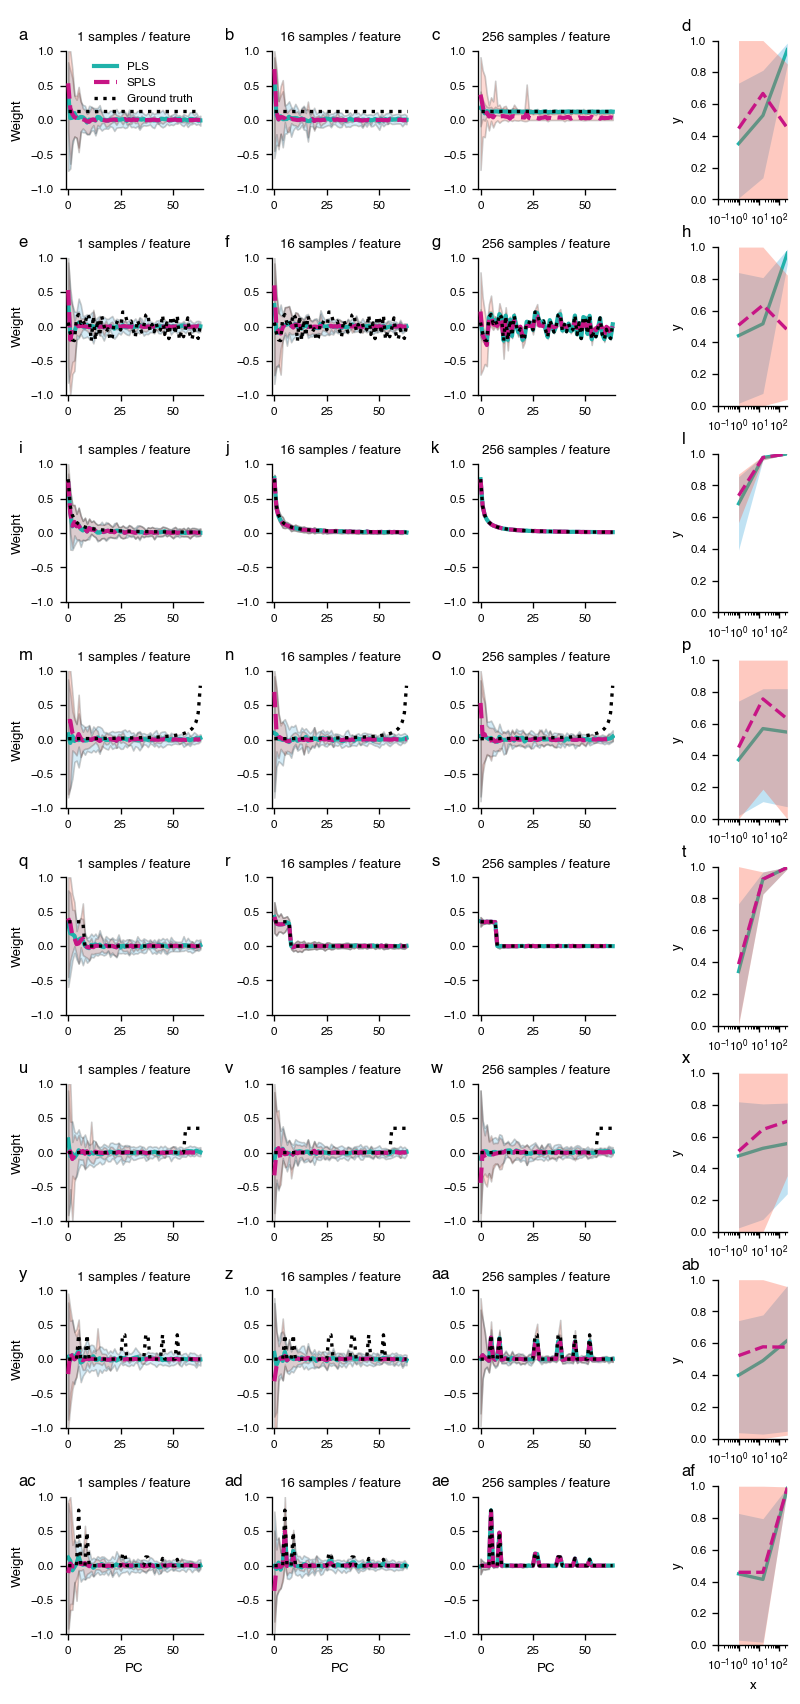

In [11]:
fig = plot_all(res_pls, n_per_ftrs=None)
fig

In [12]:
hv.save(fig, 'fig/figS_spls.pdf')